In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Authenticate Spotify API

In [73]:
# Authenticating....

clientID = '76f800b58144403a88a52b67eb7708ed'
clientSecret = '7a560acfb8cc4f43b28766bc1683d822'
redirect_uri = 'http://localhost:8888'
username = "ashiquemahmood"


scope = 'user-library-read playlist-read-private'
token = util.prompt_for_user_token(username
                                   , scope,client_id=clientID,
                                  client_secret=clientSecret,
                                  redirect_uri=redirect_uri)
if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

### Get playlist IDs

In [3]:
playlists = sp.user_playlists(username)

In [4]:
for playlist in playlists['items']:
    if playlist['name'] == 'like':
        print(playlist['id'])
        likeId = playlist['id']
    if playlist['name'] == 'dislike':
        print(playlist['id'])
        dislikeId = playlist['id']
    

5sq1Dvla1U7a8LGFKBduLn
4ESdFDYte6M94ToYGMfWYb


### Get Audio Features for songs we like

In [96]:
def get_audio_features(playlist,label):
    songIds = []
    songNames = []
    songFeatures = []
    
    tracks = playlist['tracks']
    songs = tracks['items']
    
    while tracks['next']:
        tracks = sp.next(tracks)
        for item in tracks['items']:
            songs.append(item)
    
    for song in songs:
        songIds.append(song['track']['id'])
        songNames.append(song['track']['name'])
    
    for i in range(0,len(songs),50):
        features = sp.audio_features(songIds[i:50+i])
        for i,feature in enumerate(features):
            if feature is not None:
                songFeatures.append(feature)
            else:
                del songNames[i]
    
    
    data = pd.DataFrame(songFeatures)
    data['name'] = songNames
    data['target'] = label
    
    return data

In [6]:
like = sp.user_playlist(username,likeId)
likeSongsFeatures = get_audio_features(like,1)

### Get Audio Features for songs we don't like

In [7]:
dislike = sp.user_playlist(username,dislikeId)
dislikeSongsFeatures = get_audio_features(dislike,0)

### Data Exploration

In [8]:
numerical = ['acousticness','danceability',
             'duration_ms','energy','instrumentalness',
             'key','liveness','loudness','mode',
            'speechiness','tempo','time_signature','valence']

likeData = likeSongsFeatures[numerical]
dislikeData = dislikeSongsFeatures[numerical]

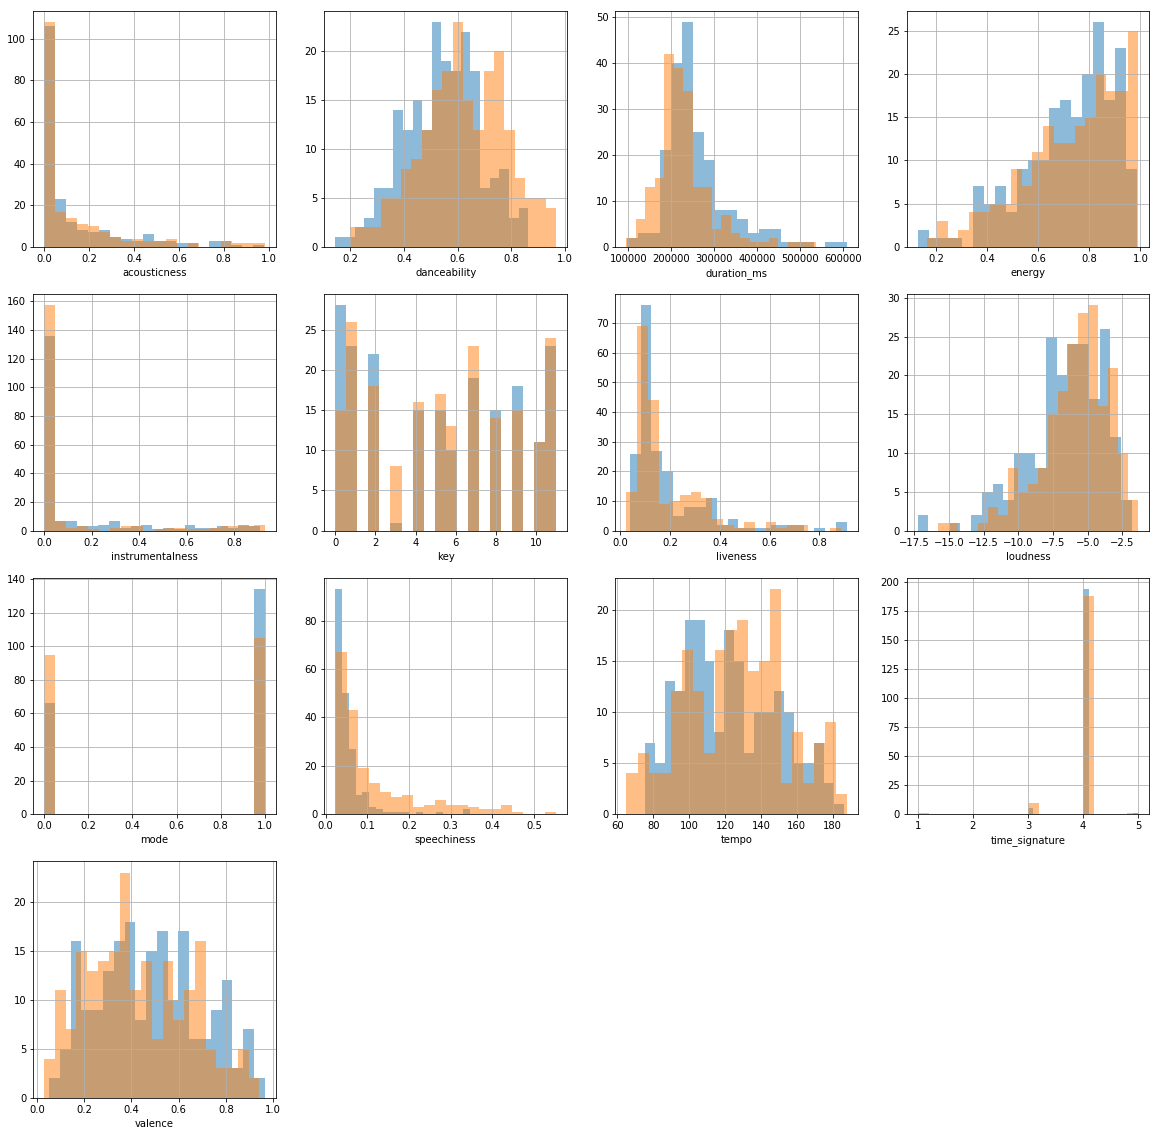

In [9]:
#Visualizing the data
fig = plt.figure(figsize=(20,20))

for i,feature in enumerate(likeData):
    plt.subplot(4,4,(i+1))
    likeData[feature].hist(alpha=0.5,bins= 20)
    dislikeData[feature].hist(alpha=0.5,bins= 20)
    plt.xlabel(feature)
    

From the plots above, we can observe skewness for some of the features. Let's find out which ones we need to transform:

In [10]:
data = pd.concat([likeSongsFeatures,dislikeSongsFeatures])
features = data[numerical]
labels = data['target']

for feature in features:
    print('{}: {:.3f}'.format(feature,features[feature].skew()))

acousticness: 1.952
danceability: -0.092
duration_ms: 1.593
energy: -0.790
instrumentalness: 2.087
key: 0.040
liveness: 2.134
loudness: -1.015
mode: -0.399
speechiness: 2.450
tempo: 0.168
time_signature: -5.805
valence: 0.232


### Data Preprocessing

In [11]:
#Applying logarithmic transformation to skewed data:
skewed = ['acousticness','instrumentalness','liveness','speechiness']
features_log_transformed = pd.DataFrame(data=features)
features_log_transformed[skewed] = features_log_transformed[skewed].apply(lambda x: np.log(x+0.1)) 

In [12]:
#Normalizing all numerical features:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features_log_scaled = pd.DataFrame(data = features_log_transformed)
features_log_scaled[numerical] = scaler.fit_transform(features_log_scaled[numerical])

In [13]:
features_log_scaled.head(n=5)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.382933,0.493301,0.560854,0.878472,0.695226,0.181818,0.144234,0.755631,1.0,0.136129,0.504140,0.75,0.164522
1,0.162280,0.285018,0.926782,0.758102,0.916629,1.000000,0.513689,0.572354,1.0,0.058386,0.298285,0.75,0.554912
2,0.002547,0.364190,0.498088,0.939815,0.040322,0.545455,0.074441,0.769662,1.0,0.077933,0.691840,0.75,0.701845
3,0.588155,0.216809,0.848730,0.678241,0.472501,0.545455,0.274425,0.674783,1.0,0.029440,0.564036,0.75,0.195624
4,0.000133,0.220463,0.535373,0.913194,0.360856,0.000000,0.525305,0.775576,1.0,0.123588,0.756169,0.75,0.639640


In [14]:
#Shuffle and split data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features,
                                                   labels,
                                                   test_size = 0.2)

# Show the results of the split
print("Training set has {} samples.".format(x_train.shape[0]))
print("Testing set has {} samples.".format(x_test.shape[0]))

Training set has 320 samples.
Testing set has 80 samples.


### Training and Testing Models

In [15]:
#Lets build a training and testing pipeline for different kind of classifers
from sklearn.metrics import fbeta_score, accuracy_score
from time import time
def train_predict(learner,x_train,x_test,y_train,y_test):
    results = {}
    
    start = time()
    learner = learner.fit(x_train,y_train)
    end = time()
    
    results['train time'] = end - start

    
    start = time()
    predicted_test = learner.predict(x_test)
    predicted_train = learner.predict(x_train)
    end = time()
    
    results['prediction time'] = end - start
    
    results['accuracy score'] = accuracy_score(y_test,predicted_test)
    results['f beta score'] = fbeta_score(y_test,predicted_test,beta=1.5)
    
    return results

In [16]:
#Importing learners
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

clf_A = GaussianNB()
clf_B = SVC(random_state=3)
clf_C = AdaBoostClassifier(random_state=6)
clf_D = DecisionTreeClassifier()
clf_E = KNeighborsClassifier()
clf_F = RandomForestClassifier()

results = {}

for clf in [clf_A,clf_B,clf_C,clf_D,clf_E,clf_F]:
    learner_name = clf.__class__.__name__
    result = train_predict(clf,x_train,x_test,y_train,y_test)
    results[learner_name] = result

In [17]:
models = pd.DataFrame(data=results)
models

,AdaBoostClassifier,DecisionTreeClassifier,GaussianNB,KNeighborsClassifier,RandomForestClassifier,SVC
accuracy score,0.637500,0.600000,0.712500,0.550000,0.662500,0.625000
f beta score,0.635750,0.623140,0.820852,0.593801,0.630849,0.682035
prediction time,0.020200,0.000000,0.000000,0.000000,0.000000,0.015627
train time,0.046876,0.001003,0.000000,0.000000,0.015668,0.000000


### Tuning the Model

In [18]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

classifier = AdaBoostClassifier(random_state=6)
parameters = {'n_estimators':[50,100,150,200],'learning_rate':[1,2,3]}
scorer = make_scorer(fbeta_score,beta=0.5)

grid = GridSearchCV(classifier,parameters,scorer)
grid_models = grid.fit(x_train,y_train)

best_model = grid_models.best_estimator_

predictions = (classifier.fit(x_train,y_train)).predict(x_test)
best_model_predictions = best_model.predict(x_test)

In [19]:
print('Unoptimized models accuracy: {:.3f}   fscore:{:.3f}'.format(accuracy_score(y_test,predictions),
                                                                   fbeta_score(y_test,predictions,beta=1.5)))
print('Optimized models accuracy: {:.3f}   fscore:{:.3f}'.format(accuracy_score(y_test,best_model_predictions),
                                                                   fbeta_score(y_test,best_model_predictions,beta=1.5)))

Unoptimized models accuracy: 0.637   fscore:0.636
Optimized models accuracy: 0.637   fscore:0.636


In [28]:
#GaussianNB Model
gNb = GaussianNB()
gNb = gNb.fit(x_train,y_train)
final_preds = gNb.predict(x_test)

### Load a playlist to predict songs

In [38]:
playlists = sp.user_playlists(username)

In [49]:
for playlist in playlists['items']:
    if playlist['name'] == 'Release Radar':
        releaseRadarId = playlist['id'] 
        print (playlist['id'])
        

37i9dQZEVXbv42FzbujTgF


In [107]:
releaseRadar = sp.user_playlist(username,releaseRadarId)
releaseFeatures = get_audio_features(releaseRadar,1)

In [111]:
# Preprocess target playlist features for prediction
targetPlaylist = releaseFeatures[numerical]
targetPlaylist_log_transformed = pd.DataFrame(data=targetPlaylist)
targetPlaylist_log_transformed[skewed] = targetPlaylist_log_transformed[skewed].apply(lambda x: np.log(x+0.1)) 

targetPlaylist_log_scaled = pd.DataFrame(data = targetPlaylist_log_transformed)
targetPlaylist_log_scaled[numerical] = scaler.fit_transform(targetPlaylist_log_scaled[numerical])

In [113]:
playlist_predictions = gNb.predict(targetPlaylist_log_scaled)

In [118]:
songNames = releaseFeatures['name']
for i, like in enumerate(playlist_predictions):
    print(songNames[i], like)

Gold Rush 1
Saving Grace (Acoustic) 1
Blue Girl (Say Goodbye) 1
James - Sonic Boom Remix 1
Three Little Birds 0
Crush 1
Shed a Tear 1
Carry Me Home (feat. Jake Reese) 0
Movin' 1
Handyman - Acoustic 1
Rich Sex (feat. Lil Wayne) 0
Saturday Sun - Luca Schreiner Remix 0
Drink and a Quick Decision 1
The Middle 1
You 0
Radio - Cut Copy Remix 1
Lost In Translation 1
Why Can't I Change 1
Your Honor 1
Jade 1
Bluebird 1
Atlas: Five 0
Walk On Minks 0
The Rover 1
Welcome To The Jungle - 1986 Sound City Session 0
Mary Don't You Weep - Piano & A Microphone 1983 Version 1
Foreign Woods (ABGT285) 1
The Island, Pt. 1 (Dawn) - Skrillex Remix 0
I'm Upset 0
